<h1><center>IST 707: Data Analytics</center>
<center>HW3: NBC, KNN, SVM, and Ensemble Learning</center></h1>

<h2><left>Name: Tanishk Parihar</left>
<br><left>Date of Submission: 04/05/2020</left></h2>

## Problem Statement

In this homework assignment, we have to make use of multiple machine learning algorithms, including naive
Bayes classifier, K Nearest Neighbor, Support Vector Machine (with both linear and non-linear kernel
functions), Random Forest and Gradient Boosting Classifier to build a disease diagnosis model. It is a binary
classification problem to predict whether or not a patient has a certain unspecified disease.


## Dataset
**Attributes’ information about the dataset:**<br>
• Age: in years<br>
• Gender: male/female<br>
• Height: in unit of cm<br>
• Weight: in unit of kg<br>
• Low Blood Pressure: lower bound of blood pressure measurement<br>
• High Blood Pressure: higher bound of blood pressure measurement<br>
• Cholesterol: three cholesteral levels<br>
• Glucose: three glucose levels<br>
• Smoke: 1/0 regarding if the patient smokes<br>
• Alcohol: 1/0 regarding if the patient drinks alcohol<br>
• Exercise: 1/0 regarding if the patient exercises regularly<br>
***• Disease: The binary target variable. Does the patient have the disease?***<br>

In [64]:
#Importing all required libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import accuracy_score,recall_score,classification_report,precision_score,roc_auc_score,f1_score,roc_curve
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import SVC
from collections import OrderedDict
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB

## Data Preparation

In [2]:
#Reads both the data as we will be cleaning both the data simultaneously
data=pd.read_csv("Disease Prediction Training.csv")
test=pd.read_csv("Disease Prediction Testing.csv")

In [3]:
#Duplicate rows will be dropped as it will only create noise in our data
data.drop_duplicates(keep='first',inplace=True)

In [4]:
# We check for any null values in our dataset
data.isna().sum().sum()

0

In [5]:
#We do the same for the test set
test.isna().sum().sum()

0

In [6]:
# The value counts for the two classes to check if there is an imbalance  
data.Disease.value_counts()

1    24076
0    23172
Name: Disease, dtype: int64

**First we will create a BMI column, which I believe can help us to tell if a person's healthy or not, having a high BMI means a person is obese which increases the chance of person suffering from the disease. So, I think it will significantly help us in classifying our target. We can later check if this variable is helpful in our classification task by printing the feature importance of the tree algorithms.**

**BMI is calculated using weight and height, so we will first check if there is any outlier data in both the columns.**

We can clearly see that our Height data contains outlier because our data is highly skewed.


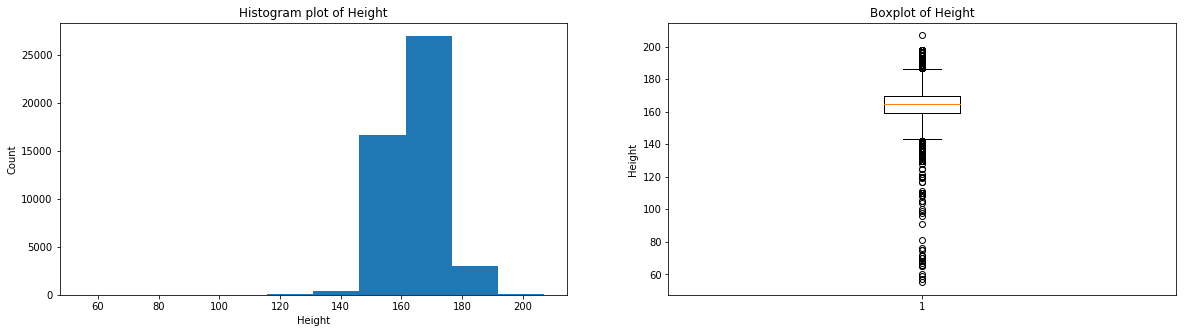

In [7]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].hist(data.Height);
ax[0].set_title("Histogram plot of Height")
ax[0].set_xlabel("Height")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Height")
ax[1].set_title("Boxplot of Height")
ax[1].boxplot(data.Height);
print("We can clearly see that our Height data contains outlier because our data is highly skewed.")

**It is very unlikely we will see people who have a height less than 120 cm given that the age of people in our data is more 20 years. So, we can clip the lower limit to 120 cm. The higher values of the data seems fine.**

In [8]:
data.Height=data["Height"].clip(lower=120)
test.Height=test["Height"].clip(lower=120)

We can clearly see that our Weight data contains outlier because our data is highly skewed.


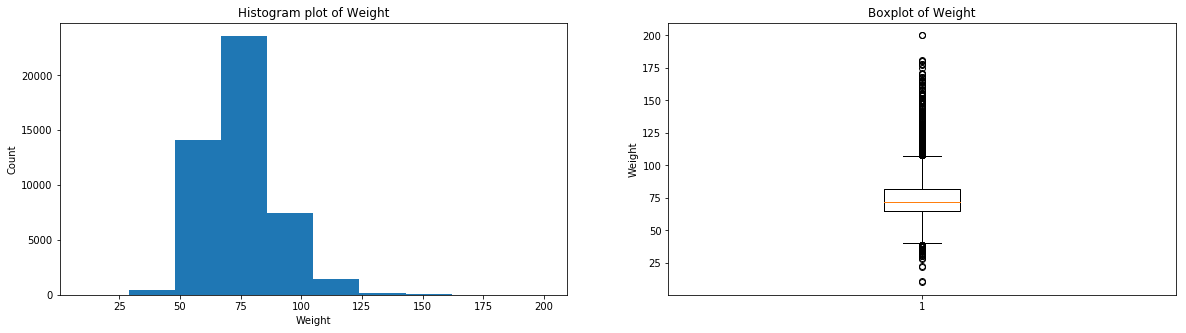

In [9]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].hist(data.Weight);
ax[0].set_title("Histogram plot of Weight")
ax[0].set_xlabel("Weight")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Weight")
ax[1].set_title("Boxplot of Weight")
ax[1].boxplot(data.Weight);
print("We can clearly see that our Weight data contains outlier because our data is highly skewed.")

**It is very unlikely we will see people who having a weight less than 40 kg given that the age of people given that the weight is not less than 120cm. So, we can clip the lower limit to 40 kg. Here also the higher values of the data seems fine.**

In [10]:
data.Weight=data.Weight.clip(lower=40)
test.Weight=test.Weight.clip(lower=40)

**Now, we have removed the outliers, we can calculate the BMI. After calculating the BMI, again we will check for outliers and remove those rows which have a really high or really low BMI values because this rows can be noise in our data which needs to be removed.**

In [11]:
data["BMI"]=data["Weight"]/((data.Height/100)**2)
test["BMI"]=test["Weight"]/((test.Height/100)**2)

**For the lower limit of BMI we have chosen 9 and higher limit is chosen as 80. Because, most of the BMI charts have this range of BMI.**

In [12]:
data[(data["BMI"]<9) | (data["BMI"]>80)]

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease,BMI
25215,52,female,120,156.0,140,90,normal,normal,0,0,1,0,108.333333
29398,53,female,120,168.0,120,80,normal,normal,1,0,1,1,116.666667
29452,47,female,125,167.0,180,90,normal,high,0,0,1,1,106.880000
38669,57,female,122,161.0,120,80,normal,normal,0,0,1,1,108.169847
46982,54,female,120,159.0,200,100,too high,normal,0,0,0,1,110.416667


In [13]:
data.drop(data[(data["BMI"]<9) | (data["BMI"]>80)].index,inplace=True)

**Now, we check Low Blood Pressure and High Blood Pressure column if there are any outliers in the data.**

We can clearly see that our Low Blood Pressure data contains outlier because our data is very highly skewed


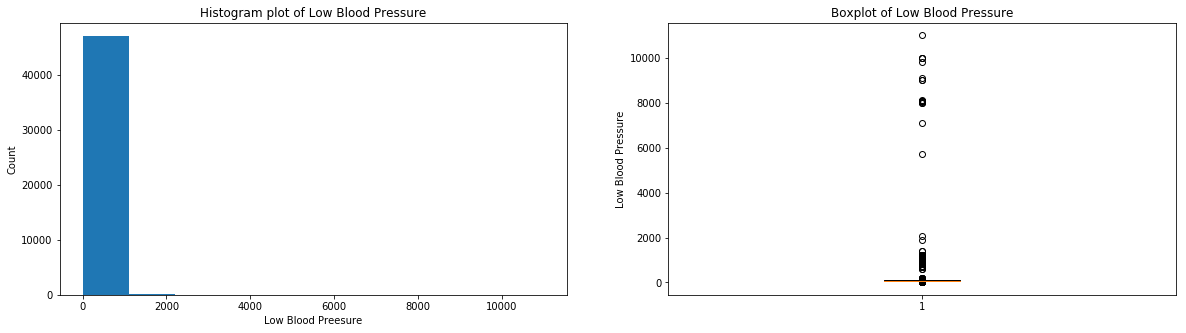

In [14]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].hist(data["Low Blood Pressure"]);
ax[0].set_title("Histogram plot of Low Blood Pressure")
ax[0].set_xlabel("Low Blood Preesure")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Low Blood Pressure")
ax[1].set_title("Boxplot of Low Blood Pressure")
ax[1].boxplot(data["Low Blood Pressure"]);
print("We can clearly see that our Low Blood Pressure data contains outlier because our data is very highly skewed")

**We use the lower limit and higher limit of low blood pressure that is usually the limits used in the medical domain and trim the values.**

In [15]:
data["Low Blood Pressure"]=data["Low Blood Pressure"].clip(lower=40)
data["Low Blood Pressure"]=data["Low Blood Pressure"].clip(upper=160)
test["Low Blood Pressure"]=test["Low Blood Pressure"].clip(lower=40)
test["Low Blood Pressure"]=test["Low Blood Pressure"].clip(upper=160)

We can clearly see that our High Blood Pressure data contains outlier because our data is very highly skewed


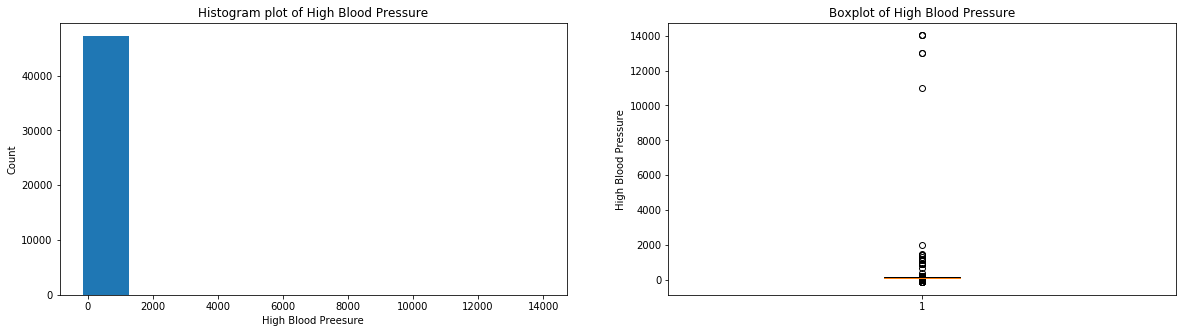

In [16]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].hist(data["High Blood Pressure"]);
ax[0].set_title("Histogram plot of High Blood Pressure")
ax[0].set_xlabel("High Blood Preesure")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("High Blood Pressure")
ax[1].set_title("Boxplot of High Blood Pressure")
ax[1].boxplot(data["High Blood Pressure"]);
print("We can clearly see that our High Blood Pressure data contains outlier because our data is very highly skewed")

**Again, we will trim the values using the limits used in the medical domain for High Blood Pressure.**

In [17]:
data["High Blood Pressure"]=data["High Blood Pressure"].clip(lower=60)
data["High Blood Pressure"]=data["High Blood Pressure"].clip(upper=250)
test["High Blood Pressure"]=test["High Blood Pressure"].clip(lower=60)
test["High Blood Pressure"]=test["High Blood Pressure"].clip(upper=250)

**Next, we check if there are any error in the values of other columns.**

In [18]:
for i in ['Gender','Cholesterol','Glucose', 'Smoke', 'Alcohol','Exercise', 'Disease']:
    print(data[i].unique())

['female' 'male']
['normal' 'high' 'too high']
['normal' 'high' 'too high']
[0 1]
[0 1]
[1 0]
[0 1]


**By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.**

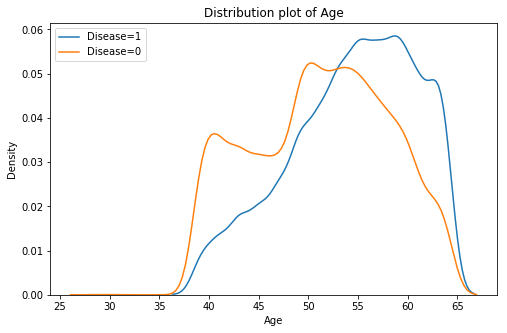

In [19]:
fig,ax=plt.subplots(1,figsize=(8,5))
ax.set_title("Distribution plot of Age")
ax.set_ylabel("Density")
sns.distplot(data.Age[data.Disease==1],hist=False,label="Disease=1",ax=ax)
sns.distplot(data.Age[data.Disease==0],hist=False,label="Disease=0",ax=ax);

**We see that the Disease=1 is slightly skewed to the right so we can expect the age to be helpful in predicting if a person has a disease or not.**

**We will divide the age groups to form bins to see that if it can help us to predict the outcome.**

In [20]:
data["Age_binned"]=pd.cut(data.Age,np.linspace(25,65,9),labels=np.arange(8))
test["Age_binned"]=pd.cut(test.Age,np.linspace(25,65,9),labels=np.arange(8))

Mean of the people having the disease by age group:


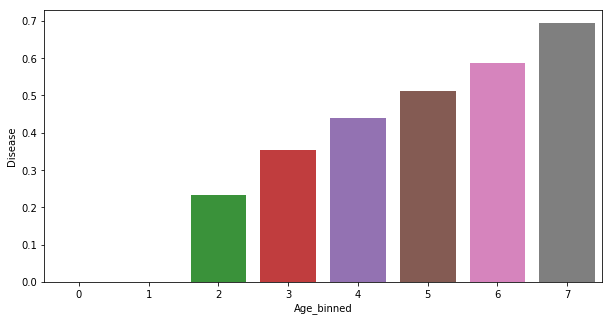

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(data.groupby("Age_binned")["Disease"].mean().index,data.groupby("Age_binned")["Disease"].mean());
print("Mean of the people having the disease by age group:")

**Clearly, we can see that the binning can help us in the prediction of the disease outcome as the age increases the probabilty of getting the disease.**

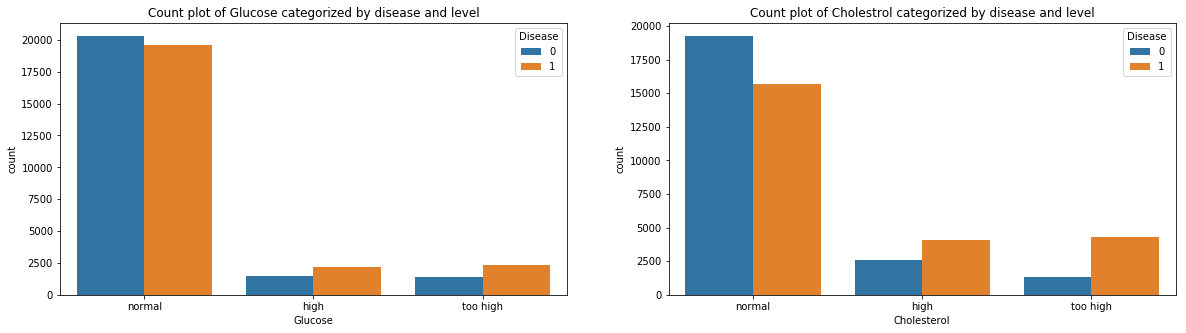

In [22]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.countplot(data=data,x="Glucose",hue="Disease",ax=ax[0]);
ax[0].set_title("Count plot of Glucose categorized by disease and level")
sns.countplot(data=data,x="Cholesterol",hue="Disease",ax=ax[1])
ax[1].set_title("Count plot of Cholestrol categorized by disease and level");

In [23]:
# Function to plot ROC_AUC_curve

def ROC_AUC_curve(model,model_name="Model"):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Decision Tree: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(8,4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

## Data Transformation

**Converting the categorical columns into binary data.**

In [24]:
data.Gender.replace({"female":0,"male":1},inplace=True)
test.Gender.replace({"female":0,"male":1},inplace=True)

In [25]:
# One-hot encoding the categorical column
data=pd.get_dummies(data)
test=pd.get_dummies(test)

In [26]:
# Drop the columns because we drop one column when one hot encoding because n-1 contains the sufficient information so we can
# drop the nth column
data.drop(["Age",'Cholesterol_too high','Glucose_too high','Age_binned_7'],inplace=True,axis=1)
test.drop(["Age",'Cholesterol_too high','Glucose_too high','Age_binned_7'],inplace=True,axis=1)

**We split the data to get our train and test, which will help us to evaluate how well our model runs on unseen data.**

In [27]:
X_train,X_test,y_train,y_test=train_test_split(data[data.columns[data.columns!="Disease"]],data.Disease,random_state=42,test_size=.15)

**Next we scale our data so that we can make the data suitable for training on some models which require preprocessed data.**

In [28]:
scaler=StandardScaler()

In [29]:
X_train[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure',"BMI"]]=scaler.fit_transform(X_train[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']])

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [30]:
test[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure',"BMI"]]=scaler.fit_transform(test[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']])

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [31]:
X_test[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']]=scaler.transform(X_test[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure',"BMI"]])

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [32]:
final_prediction=pd.DataFrame()

In [33]:
final_prediction["ID"]=test.pop("ID")

## Model Building

Metrics for tuning: When predicting disease we use recall we want our model to predict the disease as much times from the actual number of cases of disease. The metrics for tuning here used is accuracy because the models were giving more stable results on test set when performing tuning using accuracy. Also, it is safe to use the accuracy as metrics because the classes are balanced and the recall score on test set are better when accuracy was used as tuning parameter rather than recall as the tuning metrics.

Cross Validation: 6 folds have been used for tuning the model to get a good generalized model and use as much as possible data for training the model. 

Grid Search and Randomized Grid Search: A simple grid search will try all combination for getting the hyperparameters which have the best average score on the all the testing folds. But, a randomized search cv uses the same objective but instead of trying all the combinations it uses only certain specified number of combinations. Although, it seems like the Randomized search won't be able to perform as well as the grid search but it saves a lot of training time and gives results which are in par with the results given by grid search. **For Random Forest and Gradient Boosting Machines, I have used Randomized Search which uses a random state so that it reproduces all the results by taking the same specified combination from the grid that we provide.**

**Threshold Tuning for Prediction(for models which have predict_proba method): We can see that although our accuracy is good but the recall is low, when predicting disease we want a high recall. So, by reducing the threshold the recall increased. It is safe to reduce the threshold in this case because we don't want to miss out on the cases which although predicted with low probabilty of being positive by our model but in actual  are positive.**

### Linear SVM

We start our model building process by using a Linear SVM Model. It is a simple model and its training does not take lot of time. For tuning the model we will be tuning the C parameter and the regularisation parameter.

The C parameter tells the model how much you want to avoid misclassifying each training examples. Large values of C means that the otimizer will look for a smaller margin classifier even if it means classifying the data incorrectly. While, the larger C value look for classifying the data correctly even if it means it has to build a small margin classifier

The penalty is the l1 and l2 regularisation parameter. The l1 and l2 both penalize the points and make the models less susceptible to outliers and improve its overall generalization.

In [34]:
svm=LinearSVC(random_state=42,dual=False)

In [35]:
param_grid_svm={"C":[.001,.005,.01,.1,.2,.4,.8,1,10],"penalty":["l1","l2"]}

In [36]:
grid_search_svm=GridSearchCV(estimator=svm,param_grid=param_grid_svm,cv=6,scoring="accuracy")

In [109]:
grid_search_svm.fit(X_train,y_train)

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.005, 0.01, 0.1, 0.2, 0.4, 0.8, 1, 10], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [38]:
best_params_svm=grid_search_svm.best_params_
print(best_params_svm)

{'C': 0.01, 'penalty': 'l2'}


In [39]:
#printing the training accuracy
accuracy_score(grid_search_svm.predict(X_train),y_train)

0.7271391572865823

In [40]:
#printing the testing accuracy
accuracy_score(grid_search_svm.predict(X_test),y_test)

0.7392408635529844

In [41]:
print(classification_report(y_true=y_test,y_pred=grid_search_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      3501
           1       0.76      0.70      0.73      3586

   micro avg       0.74      0.74      0.74      7087
   macro avg       0.74      0.74      0.74      7087
weighted avg       0.74      0.74      0.74      7087



In [42]:
test_predict_svm=grid_search_svm.predict(test)

### RBF Kernel SVM

RBF Kernels are used when the data is not linearly separable. It divides the binary data by making a non linear decision boundary. C and gamma are two hyperparameters that are used to train a RBF-kernel based SVM classifier.

**Model Tuning:**

**C:** The higher cost aims to classify more points correctly. So a higher cost will have more variance and a lower cost will have low variance as it will try to get a smoother decision boundary. 

**Gamma:**The RBF gamma parameter in SVM tuning signifies the influence of points either near or far away from the hyperplane. For a low gamma, the model will be too constrained and include all points of the training dataset, without really capturing the shape. So, lower gamma will give a model with high variance and higher gamma will give a model with high bias and low variance.

In [43]:
rbf_svm=SVC(kernel="rbf",random_state=42)

In [44]:
param_grid_rsvm={"C":[.01,.1,.4,.8,1,10],"gamma":[0.1,0.4,0.8,1,10]}

In [45]:
grid_search_rsvm=GridSearchCV(estimator=rbf_svm,param_grid=param_grid_rsvm,cv=6,scoring="accuracy",verbose=1,n_jobs=-1)

In [46]:
grid_search_rsvm.fit(X_train,y_train)

Fitting 6 folds for each of 30 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 205.0min finished


GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 0.4, 0.8, 1, 10], 'gamma': [0.1, 0.4, 0.8, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [47]:
best_params_rsvm=grid_search_rsvm.best_params_
print(best_params_rsvm)

{'C': 0.8, 'gamma': 0.1}


In [48]:
#printing the training accuracy
accuracy_score(grid_search_rsvm.predict(X_train),y_train)

0.7350831756151011

In [49]:
#printing the testing accuracy
accuracy_score(y_test,grid_search_rsvm.predict(X_test))

0.7426273458445041

In [50]:
print(classification_report(y_test,grid_search_rsvm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75      3501
           1       0.77      0.70      0.73      3586

   micro avg       0.74      0.74      0.74      7087
   macro avg       0.74      0.74      0.74      7087
weighted avg       0.75      0.74      0.74      7087



In [51]:
test_predict_rsvm=grid_search_rsvm.predict(test)

### Random Forest Classifier

A Random Forest Classifier uses a group of decision trees in order to make a decision. A decision tree usually overfits the data, but a random forest is able to better generalize. So, Random Forest are better at making decision than a simple decision tree. The class that is predicted is simply the class with the highest average class probability

**Model Tuning:** 

**n_estimators:**The important tuning parameter of the Random Forest is the number of trees to be used for predicting the result. 
<br>**max_features:** The max_features is the number of features that will be used for making a single tree. For eg using "sqrt", the tree uses the square root of the number of total features in the data. Using auto is the same as making use of sqrt. The other values can be specifying the int(number of features to be used less than the total features), log, and proportion of the features to be used.
<br>**min_samples_leaf:** The minimum number of samples that should be there in leaf node. If the number is less then the leaf node is pruned.
<br>**min_samples_split:** The number of samples that should be present in the node for it to be split further.

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
rm=RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=100)

In [54]:
param_grid_rm={'max_depth': [1,25,10, 20, 100],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [10,30,50,100],
             'min_samples_split': [500,800,1000],
             'n_estimators': [100,200,500, 1000, 2000]}

In [55]:
grid_search_rm=RandomizedSearchCV(estimator=rm,param_distributions=param_grid_rm,cv=6,scoring="accuracy",n_iter=100,verbose=1,n_jobs=-1,random_state=42)

In [56]:
grid_search_rm.fit(X_train,y_train)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 32.9min finished


RandomizedSearchCV(cv=6, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'min_samples_split': [500, 800, 1000], 'min_samples_leaf': [10, 30, 50, 100], 'max_depth': [1, 25, 10, 20, 100], 'n_estimators': [100, 200, 500, 1000, 2000], 'max_features': ['auto', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=1)

In [57]:
#printing the training accuracy
accuracy_score(grid_search_rm.predict(X_train),y_train)

0.7300029883454527

In [58]:
#printing the testing accuracy
accuracy_score(grid_search_rm.predict(X_test),y_test)

0.7378298292648512

In [59]:
print(classification_report(y_true=y_test,y_pred=grid_search_rm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.78      0.75      3501
           1       0.77      0.70      0.73      3586

   micro avg       0.74      0.74      0.74      7087
   macro avg       0.74      0.74      0.74      7087
weighted avg       0.74      0.74      0.74      7087



In [60]:
#Changing the threshold to tune the recall to improve
print(classification_report(y_true=y_test,y_pred=(grid_search_rm.predict_proba(X_test)[:,1]>0.45).astype(int)))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73      3501
           1       0.74      0.74      0.74      3586

   micro avg       0.74      0.74      0.74      7087
   macro avg       0.74      0.74      0.74      7087
weighted avg       0.74      0.74      0.74      7087



In [61]:
best_params_rm=grid_search_rm.best_params_
print(best_params_rm)

{'min_samples_split': 500, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'n_estimators': 2000, 'max_depth': 10}


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.807


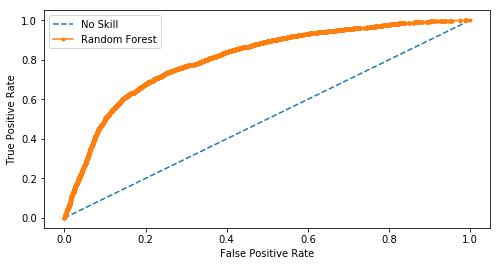

In [62]:
ROC_AUC_curve(model=grid_search_rm,model_name="Random Forest")

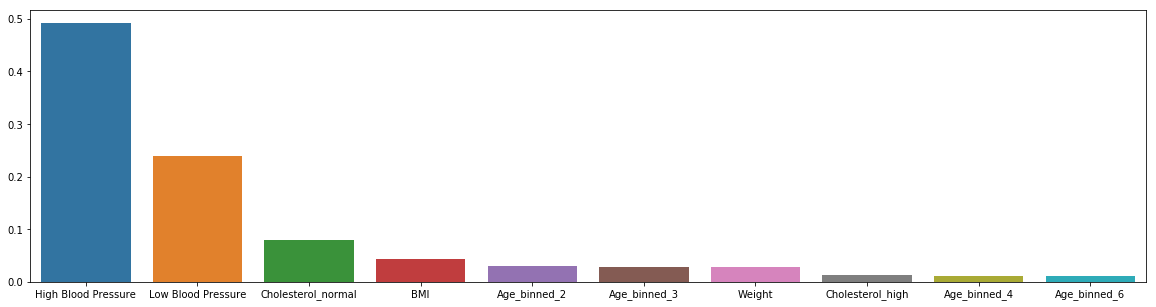

In [67]:
plt.figure(figsize=(20,5))
feature_importance_rm=OrderedDict(sorted(zip(X_train.columns,grid_search_rm.best_estimator_.feature_importances_),reverse=True,key=lambda x:x[1]))
sns.barplot(list(feature_importance_rm.keys())[:10],list(feature_importance_rm.values())[:10]);

In [68]:
# Changing the threshold to get a better recall
test_predict_rm=(grid_search_rm.predict_proba(test)[:,1]>0.45).astype(int)

### K- Nearest Neighbors

**Model Tuning:**

**n_neighbors:** Specifies the number of neighbors to be considered for classifying the point.
<br>**weights:** If the weights are set to uniform then all the k points are assigned equal weigts for classification, else if teh distance is used the closest points are given more weight and has more priority when classifying the point
<br>**p**: It defines the distance function that should be used i.e. manhattan or euclidean.

In [69]:
from sklearn.neighbors import KNeighborsClassifier

In [70]:
knn=KNeighborsClassifier()

In [71]:
param_grid_knn={"n_neighbors":[30,50,80,100,150,200,500,1000],"weights":["uniform","distance"],"p":[1,2]}

In [72]:
grid_search_knn=GridSearchCV(estimator=knn,n_jobs=-1,param_grid=param_grid_knn,scoring="accuracy",verbose=1)

In [73]:
grid_search_knn.fit(X_train,y_train)

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 24.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'p': [1, 2], 'n_neighbors': [30, 50, 80, 100, 150, 200, 500, 1000], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [74]:
#printing the training accuracy
accuracy_score(grid_search_knn.predict(X_train),y_train)

0.725669887438988

In [75]:
#printing the testing accuracy
accuracy_score(grid_search_knn.predict(X_test),y_test)

0.7381120361224778

In [76]:
print(classification_report(y_true=y_test,y_pred=grid_search_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3501
           1       0.77      0.69      0.73      3586

   micro avg       0.74      0.74      0.74      7087
   macro avg       0.74      0.74      0.74      7087
weighted avg       0.74      0.74      0.74      7087



In [77]:
#Changing the threshold to tune the recall to improve
print(classification_report(y_true=y_test,y_pred=(grid_search_knn.predict_proba(X_test)[:,1]>0.45).astype(int)))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      3501
           1       0.73      0.75      0.74      3586

   micro avg       0.73      0.73      0.73      7087
   macro avg       0.74      0.73      0.73      7087
weighted avg       0.73      0.73      0.73      7087



In [78]:
best_params_knn=grid_search_knn.best_params_
print(best_params_knn)

{'p': 1, 'n_neighbors': 100, 'weights': 'uniform'}


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.803


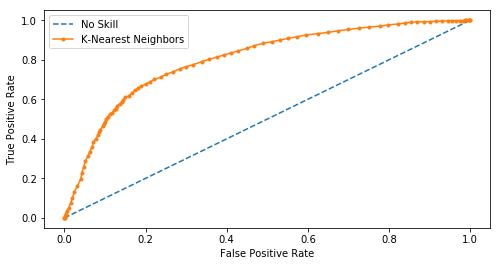

In [79]:
ROC_AUC_curve(model=grid_search_knn,model_name="K-Nearest Neighbors")

In [80]:
# Changing the threshold to get a better recall
test_predict_knn=(grid_search_knn.predict_proba(test)[:,1]>0.45).astype(int)

### Gradient Boosting Machines

Gradient Boosting are build using number of trees just like random forest but here we keep on improving the individual base learner by giving more weights to the points where the previous learner made an error.

**Model Tuning:** 

**n_estimators:** The important tuning parameter of the Random Forest is the number of trees to be used for predicting the result. 
<br>**max_features:** The max_features is the number of features that will be used for making a single tree. For eg using "sqrt", the tree uses the square root of the number of total features in the data. Using auto is the same as making use of sqrt. The other values can be specifying the int(number of features to be used less than the total features), log, and proportion of the features to be used.
<br>**min_samples_leaf:** The minimum number of samples that should be there in leaf node. If the number is less then the leaf node is pruned.
<br>**min_samples_split:** The number of samples that should be present in the node for it to be split further.
<br>**sub_sample:** The proportion of sample to be used for training individual base learner.

In [81]:
from sklearn.ensemble import GradientBoostingClassifier

In [82]:
gbm=GradientBoostingClassifier(random_state=42)

In [83]:
param_grid_gbm={'max_features': ['auto','sqrt'],
              'n_estimators': [100,200,500],
              'subsample':[0.6,0.8,0.9],
              'max_depth': [1,5,20,10,50,100],
              'min_samples_split':[500,800,1000],
              'min_samples_leaf':[10,30,50,100]}

In [84]:
grid_search_gbm=RandomizedSearchCV(estimator=gbm,param_distributions=param_grid_gbm,cv=6,scoring="accuracy",n_iter=100,verbose=1,n_jobs=-1,random_state=42)

In [85]:
grid_search_gbm.fit(X_train,y_train)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 50.9min finished


RandomizedSearchCV(cv=6, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'min_samples_split': [500, 800, 1000], 'max_features': ['auto', 'sqrt'], 'n_estimators': [100, 200, 500], 'min_samples_leaf': [10, 30, 50, 100], 'subsample': [0.6, 0.8, 0.9], 'max_depth': [1, 5, 20, 10, 50, 100]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=1)

In [86]:
#printing the training accuracy
accuracy_score(grid_search_gbm.predict(X_train),y_train)

0.7387189959159279

In [87]:
#printing the testing accuracy
accuracy_score(grid_search_gbm.predict(X_test),y_test)

0.7441794835614506

In [88]:
print(classification_report(y_true=y_test,y_pred=grid_search_gbm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      3501
           1       0.77      0.71      0.74      3586

   micro avg       0.74      0.74      0.74      7087
   macro avg       0.75      0.74      0.74      7087
weighted avg       0.75      0.74      0.74      7087



In [89]:
#Changing the threshold to tune the recall to improve
print(classification_report(y_true=y_test,y_pred=(grid_search_gbm.predict_proba(X_test)[:,1]>0.45).astype(int)))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      3501
           1       0.74      0.76      0.75      3586

   micro avg       0.74      0.74      0.74      7087
   macro avg       0.75      0.74      0.74      7087
weighted avg       0.74      0.74      0.74      7087



In [90]:
best_params_gbm=grid_search_gbm.best_params_
print(best_params_gbm)

{'min_samples_split': 1000, 'max_features': 'auto', 'n_estimators': 100, 'min_samples_leaf': 30, 'subsample': 0.6, 'max_depth': 5}


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.813


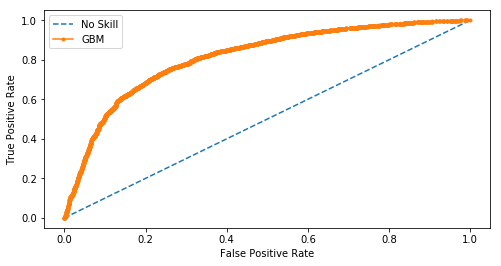

In [91]:
ROC_AUC_curve(model=grid_search_gbm,model_name="GBM")

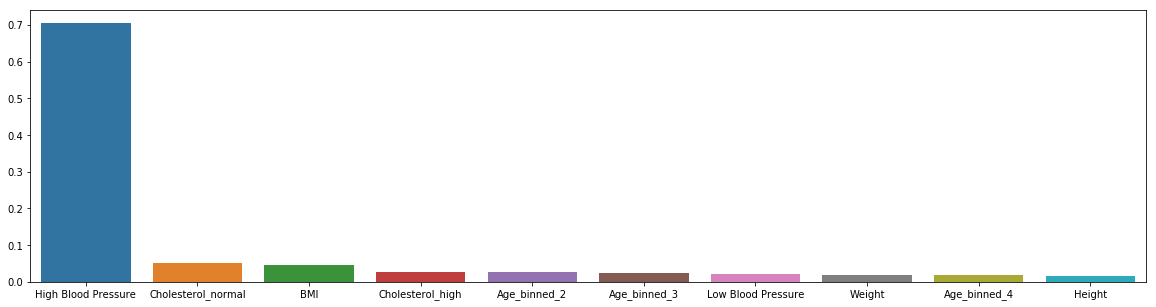

In [92]:
plt.figure(figsize=(20,5))
feature_importance_gbm=OrderedDict(sorted(zip(X_train.columns,grid_search_gbm.best_estimator_.feature_importances_),reverse=True,key=lambda x:x[1]))
sns.barplot(list(feature_importance_gbm.keys())[:10],list(feature_importance_gbm.values())[:10]);

In [93]:
# Changing the threshold to get a better recall
test_predict_gbm=(grid_search_gbm.predict_proba(test)[:,1]>0.45).astype(int)

### Naive Bayes Classifier

Model Tuning:

Var_Smoothing is a smoothing parameter that is portion of the largest variance of all features that is added to variances for calculation stability.(as given in the sklearn documentation)

In [94]:
nb=GaussianNB()

In [95]:
param_grid_nb={"var_smoothing":[1e-9,.001,.005,.01,.1,.3,.5]}

In [96]:
grid_search_nb=GridSearchCV(estimator=nb,param_grid=param_grid_nb,cv=6,scoring="accuracy",verbose=1,n_jobs=-1)

In [97]:
grid_search_nb.fit(X_train,y_train)

Fitting 6 folds for each of 7 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    1.5s finished


GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=GaussianNB(priors=None, var_smoothing=1e-09),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'var_smoothing': [1e-09, 0.001, 0.005, 0.01, 0.1, 0.3, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [98]:
#printing the training accuracy
accuracy_score(grid_search_nb.predict(X_train),y_train)

0.6915778463990437

In [99]:
#printing the testing accuracy
accuracy_score(grid_search_nb.predict(X_test),y_test)

0.7060815577818541

In [100]:
print(classification_report(y_true=y_test,y_pred=grid_search_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73      3501
           1       0.76      0.62      0.68      3586

   micro avg       0.71      0.71      0.71      7087
   macro avg       0.71      0.71      0.70      7087
weighted avg       0.71      0.71      0.70      7087



In [101]:
#Changing the threshold to tune the recall to improve
print(classification_report(y_true=y_test,y_pred=(grid_search_nb.predict_proba(X_test)[:,1]>0.35).astype(int)))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71      3501
           1       0.71      0.72      0.72      3586

   micro avg       0.71      0.71      0.71      7087
   macro avg       0.71      0.71      0.71      7087
weighted avg       0.71      0.71      0.71      7087



In [102]:
best_params_nb=grid_search_nb.best_params_
print(best_params_nb)

{'var_smoothing': 0.1}


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.779


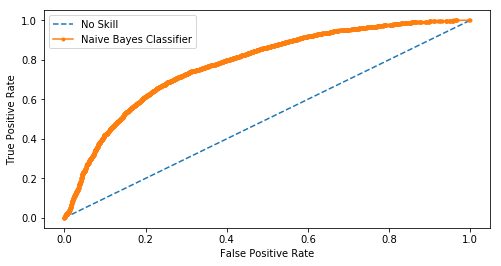

In [103]:
ROC_AUC_curve(model=grid_search_nb,model_name="Naive Bayes Classifier")

In [104]:
# Changing the threshold to get a better recall
test_predict_nb=(grid_search_nb.predict_proba(test)[:,1]>0.35).astype(int)

## Prediction and Interpretation

In [105]:
[[{i:j} for i,j in best_params_nb.items()],[{i:j} for i,j in best_params_knn.items()],[{i:j} for i,j in best_params_svm.items()],
                                        [{i:j} for i,j in best_params_rsvm.items()],[{i:j} for i,j in best_params_rm.items()],[{i:j} for i,j in best_params_gbm.items()]

SyntaxError: unexpected EOF while parsing (<ipython-input-105-2d6da18de95d>, line 2)

In [177]:
summary=pd.DataFrame({"Algorithm":["NBC","KNN","SVM-Linear","SVM-RBF","RF","GBM"], "Recall":[0.62,0.69,0.70,.70,.70,.71],"Recall after tuning threshold":[0.72,0.75,"-","-",.74,.76],"Accuracy":[0.7061,0.7381,0.7392,.7426,.7378,.7441],
                      "Hyperparameters":[[{i:j} for i,j in best_params_nb.items()],[{i:j} for i,j in best_params_knn.items()],[{i:j} for i,j in best_params_svm.items()],
                                        [{i:j} for i,j in best_params_rsvm.items()],[{i:j} for i,j in best_params_rm.items()],[{i:j} for i,j in best_params_gbm.items()]]})

In [178]:
summary

,Accuracy,Algorithm,Hyperparameters,Recall,Recall after tuning threshold
0,0.7061,NBC,[{'var_smoothing': 0.1}],0.62,0.72
1,0.7381,KNN,"[{'weights': 'uniform'}, {'p': 1}, {'n_neighbo...",0.69,0.75
2,0.7392,SVM-Linear,"[{'C': 0.01}, {'penalty': 'l2'}]",0.70,-
3,0.7426,SVM-RBF,"[{'gamma': 0.1}, {'C': 0.8}]",0.70,-
4,0.7378,RF,"[{'max_features': 'sqrt'}, {'n_estimators': 20...",0.70,0.74
5,0.7441,GBM,"[{'subsample': 0.6}, {'min_samples_split': 100...",0.71,0.76


**Interpretation and Conclusion:**

**The GBM model has the highest recall after tuning the threshold. The area under the curve is close to 0.8 for all the models which means that the model are not just randomly predicting and the true positive rate is good. The recall was increased after lowering the thresholds which mean that our model is not able to predict some of the positive cases with high confidence. **

**All the models have testing accuracy close to the training accuracy which mean that the models are able to generalize the data nicely. Also, it means that the training data and the testing data had similar distributions. So, the performance was the same on both the sets.**

**Our svm linear model has a good accuracy in predicting the data so maybe it means that a linear decision boundary could work for separating the classes.**

In [173]:
# Creating the columns for all the model predictions and storing them in the dataframe
final_prediction["NBC"]=test_predict_nb
final_prediction["KNN"]=test_predict_knn
final_prediction["SVM-Linear"]=test_predict_svm
final_prediction["SVM-RBF"]=test_predict_rsvm
final_prediction["RF"]=test_predict_rm
final_prediction["GBM"]=test_predict_gbm

In [174]:
# Storing the final predictions in csv file
final_prediction.to_csv("test_prediction.csv",index=False)